In [1]:
import pandas as pd
import numpy as np
import math
from math import log
from scipy import stats
from sklearn import preprocessing
train = pd.read_csv('data/train.csv') 
test = pd.read_csv('data/test.csv')
ID = test['id']
train.drop('id',axis=1,inplace = True)
test.drop('id',axis=1,inplace = True) 
train['n_jobs'].replace(-1,16,inplace=True) 
test['n_jobs'].replace(-1,16,inplace=True)
train.drop('random_state',axis=1,inplace = True)
test.drop('random_state',axis=1,inplace = True)
train.drop('scale',axis=1,inplace = True)
test.drop('scale',axis=1,inplace = True)
def fun2(x,y):
    if x == 'elasticnet':
        return y
    elif x == 'l1':
        return 1
    else:
        return 0
train['l1_ratio']= train.apply(lambda x: fun2(x.penalty,x.l1_ratio),axis=1)
test['l1_ratio']= test.apply(lambda x: fun2(x.penalty,x.l1_ratio),axis=1)
def fun1(x):
    y = math.log(x)
    return(y)
# train['n_samples']= train['n_samples'].apply(lambda x: fun1(x))
# test['n_samples']= test['n_samples'].apply(lambda x: fun1(x))
# train['n_features']= train['n_features'].apply(lambda x: fun1(x))
# test['n_features']= test['n_features'].apply(lambda x: fun1(x))

In [2]:
def fun4(x,y):
    z = x*y
    return(z)
train['n_cluster']= train.apply(lambda x: fun4(x.n_clusters_per_class,x.n_classes),axis=1)
test['n_cluster']= test.apply(lambda x: fun4(x.n_clusters_per_class,x.n_classes),axis=1)
def fun5(x,y,z,q):
    w = x*y*z/q
    return(w)
train['total']= train.apply(lambda x: fun5(x.n_samples,x.n_features,x.max_iter,x.n_jobs),axis=1)
test['total']= test.apply(lambda x: fun5(x.n_samples,x.n_features,x.max_iter,x.n_jobs),axis=1)
train.drop('n_samples',axis=1,inplace = True)
test.drop('n_samples',axis=1,inplace = True)
train.drop('n_features',axis=1,inplace = True)
test.drop('n_features',axis=1,inplace = True)
train.drop('max_iter',axis=1,inplace = True)
test.drop('max_iter',axis=1,inplace = True)
train.drop('n_informative',axis=1,inplace = True)
test.drop('n_informative',axis=1,inplace = True)

In [3]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train['time'] = train['time'].apply(lambda x: fun1(x))
train_Y = train['time']
train.drop('time',axis=1,inplace = True)

In [4]:
from scipy.stats import norm, skew
numeric_feats = train.dtypes[train.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
total,2.974047
penalty_l2,1.334375
penalty_l1,1.217562
penalty_none,1.094306
n_jobs,1.003699
penalty_elasticnet,0.993824
n_cluster,0.836670
alpha,0.677777
l1_ratio,0.491777
n_clusters_per_class,0.096758


In [5]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)

There are 12 skewed numerical features to Box Cox transform


In [6]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
mean = train.mean(axis=0)         #normalize features
std = train.std(axis=0)
train = (train - mean) / std
test = (test - mean) / std

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu,
                       input_shape=(train.shape[1],)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(32, activation=tf.nn.softplus),
        keras.layers.Dense(1)
    ])
    #optimizer = tf.train.RMSPropOptimizer(0.001)
    optimizer = tf.train.GradientDescentOptimizer(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,337
Trainable params: 22,337
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train, train_Y, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [9]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

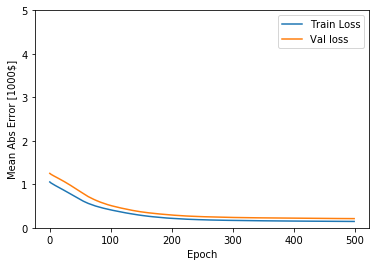

In [10]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train, train_Y, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [11]:
predictions = model.predict(test).flatten()
submission = pd.DataFrame({'Id': ID,'time': predictions})
def fun3(x):
    y = math.exp(x)
    return(y)
submission['time']= submission['time'].apply(lambda x: fun3(x))

In [12]:
submission.to_csv("./outcome.csv", index=False,header=True)

In [13]:
submission

,Id,time
0,0,1.108608
1,1,9.374393
2,2,0.421724
3,3,1.343123
4,4,2.450041
5,5,6.543397
6,6,2.747886
7,7,0.520563
8,8,13.466209
9,9,0.337694
